In [39]:
using Pkg

In [40]:
Pkg.activate(dirname(pwd()))

  Activating project at `~/Documents/GitHub/ComputationalHeatTransfer.jl`


In [41]:
using ComputationalHeatTransfer
using LaTeXStrings
using JLD2
using Plots
gr()  


Plots.GRBackend()

## Control Console

In [410]:
# fluid_type = "butane"
# fluid_type = "R134a"
# Tᵥ = 291.2

ΔTthres = 1.0
δfilm = 2e-5
plate_d = 2e-3;
# hc1 = 3000.0
# hc1 = 0.0
# hc2 = 3000.0
Eratio = 0.4

0.4

In [411]:
# fluid_type = "butane"
# Tᵥ = 291.2

# ΔTthres = 0.1
# δfilm = 1e-5
# plate_d = 2e-3;
# # hc1 = 3000.0
# hc1 = 0.0
# hc2 = 3000.0
# Eratio = 0.3

# Properies

### Solid Physical parameters

In [412]:
ρₛ = 2730; # density
cₛ  = 8.93e02; # specific heat
kₛ  = 1.93e02; # heat conductivity
params = HeatConductionParameters(ρₛ ,cₛ ,kₛ ,thickness=plate_d)

HeatConductionParameters(2730.0, 893.0, 193.0, 7.916682048820907e-5, 0.002)

### Fluid Physical parameters

In [413]:
fluid_type = "butane"
Tref = 291.2
p_fluid = SaturationFluidProperty(fluid_type,Tref);

In [414]:
# using UnPack
# @unpack Cpₗ,ρₗ,μₗ,hₗ,kₗ,Prₗ,Cpᵥ,ρᵥ,μᵥ,hᵥ,kᵥ,Prᵥ,σ,P,R,M,Rkg,αₗ,νₗ,νᵥ,hₗᵥ = p_fluid;

# Plate Conduction

### Geometry parameters

In [415]:
Lx = 0.1524; # plate size x
Ly = 0.0648; # plate size y

In [416]:
xlim = (-Lx/2,Lx/2) # plate x limits
ylim = (-Ly/2,Ly/2) # plate y limits
Δx,Δt_max = setstepsizes(params.α,gridPe=8.0,fourier=0.3)

(0.0006333345639056725, 0.001520002953373614)

## Set up the OHP

In [417]:
x, y, xf, yf = construct_ohp_curve("ASETS",Δx)
ohp = BasicBody(x,y)
ohpgeom = ComputationalHeatTransfer.LineSourceParams(ohp)

LineSourceParams{BasicBody{4877, RigidBodyTools.ClosedBody}}(Basic pointwise-specified body with 4877 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
)

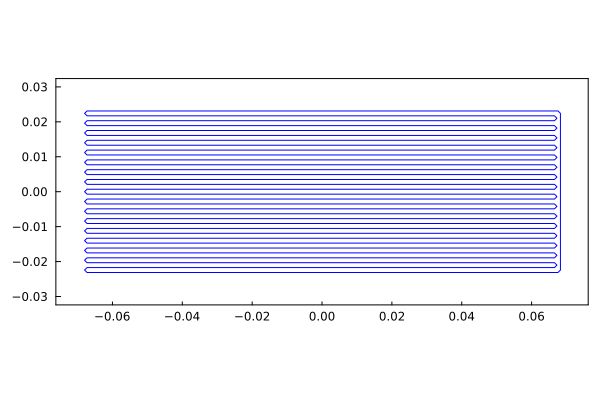

In [418]:
plot(ohpgeom.body,fillalpha=0,linecolor=:blue,xlims=xlim,ylims=ylim,framestyle = :box)

### create HeatConduction system

In [419]:
sys = HeatConduction(params,Δx,xlim,ylim,Δt_max,qline=ohpgeom)

Unbounded Heat conduction system on a grid of size 250 x 108 and 0 static immersed points


# OHP inner part

### Tube geometries

In [420]:
tube_d = 1e-3; # tube diameter
peri = 4*tube_d # Tube perimeter
Ac = tube_d*tube_d # tube cross-sectional area
L2D = 133.83*1e-3 # the actual length of the bended pipe in the real world
L = (sys.qline[1].arccoord[1] + sys.qline[1].arccoord[end])  # total length of the pipe when streched to a 1D pipe (an approximate here)
angle = 0*pi/2 # inclination angle 
closedornot = true

N=numpts(ohp);

In [421]:
tube = Tube(tube_d,peri,Ac,L,L2D,angle,gravity,closedornot,N);

In [422]:
typeof(tube)

Tube

### Liquid

In [423]:
Nu = 4.36
# Nu = 1.0
Hₗ = p_fluid.kₗ/tube_d * Nu # Nusselt number 4.36

469.1572801658905

In [424]:
# X0,realratio = randomXp(tube)
X0 = [(L/2,L/2+1e-2)]
V = 0.44
dXdt0 = [(V,V)]

1-element Vector{Tuple{Float64, Float64}}:
 (0.44, 0.44)

In [425]:
# construct liquids
N=numpts(ohp)
Xarrays,θarrays = constructXarrays(X0,N,Tref,L);

In [426]:
liquids=Liquid(Hₗ,p_fluid.ρₗ,p_fluid.Cpₗ,p_fluid.αₗ,p_fluid.μₗ,p_fluid.σ,X0,dXdt0,Xarrays,θarrays);

### Vapor

In [427]:
Hᵥ = p_fluid.kᵥ/tube_d * Nu # Nusselt number 4.36

69.29503570524817

In [428]:
P = [0.0] .+ TtoP(300.0);
# δ = 0*zeros(length(X0)) .+ 1.0e-5;
δfilm_deposit = δfilm;
δstart = [0.0] .+ δfilm ;
δend = [0.0] .+ δfilm ;

Lvaporplug = XptoLvaporplug(X0,L,tube.closedornot)
Lfilm_start = 0.01 .* Lvaporplug
Lfilm_end = 0.01 .* Lvaporplug
# Eratio = 0.75
# δratio = 0*zeros(length(X0)) .+ 0.99;
# δ = 0*zeros(length(X0)) .+ 2.78E-02;
δmin = 2e-6
vapors=Vapor(Hᵥ,p_fluid.kₗ,δmin,Eratio,P,δfilm_deposit,δstart,δend,Lfilm_start,Lfilm_end);

### Wall

### nucleate boiling sites

In [429]:
# ΔTthres = 1.0; # superheat threshold

In [430]:
    nucleatenum = 1000
#     Xstations = sort(rand(nucleatenum).*L);
    Xstations = LinRange(0.0,L-L/nucleatenum,nucleatenum)
#     boilingΔt = 0.05

1000-element LinRange{Float64, Int64}:
 0.0,0.00465067,0.00930134,0.013952,…,4.63207,4.63672,4.64137,4.64602

In [431]:
Xwallarray,θwallarray = constructXarrays(sys.qline[1].arccoord,L,Tref);
θwallarray .= Tref

wall = Wall(ΔTthres,Xstations,Xwallarray,θwallarray);

In [432]:
sys0_nomapping = PHPSystem_nomapping(tube,liquids,vapors,wall);
θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall = sys_interpolation(sys0_nomapping)
mapping = Mapping(θ_interp_walltoliquid, θ_interp_liquidtowall, H_interp_liquidtowall, P_interp_liquidtowall);

In [433]:
L

4.650670248837519

In [434]:
sys0 = PHPSystem(tube,liquids,vapors,wall,mapping);

### construct state vector U

In [435]:
Lvaporplug = XptoLvaporplug(X0,sys0.tube.L,sys0.tube.closedornot)
M = PtoD(P) .* Lvaporplug .* Ac
# M = P.^(1/γ).* Lvaporplug



u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
# u=[XMδtovec(X0,dXdt0,M,δ); liquidθtovec(sys0.liquid.θarrays)];

In [436]:
function const_temp_condition(u,t,integrator)
    true
end

const_temp_condition (generic function with 1 method)

In [437]:
P

1-element Vector{Float64}:
 257596.14635476272

In [438]:
function const_temp_affect!(integrator)
    integrator.p.vapor.P = P
end

const_temp_affect! (generic function with 1 method)

In [439]:
# cb_boiling =  DiscreteCallback(boiling_condition,boiling_affect!)
# cb_boiling =  PeriodicCallback(boiling_affect!,0.01*t_to_nondi_t)
# cb_vapormerging =  DiscreteCallback(merging_condition,merging_affect!)
# cb_liquidmerging = DiscreteCallback(vaporMergingCondition,vaporMergingAffect!)
cb_fixdx =  DiscreteCallback(fixdx_condition,fixdx_affect!)
# cb_immersedboundary = DiscreteCallback(immersedboundary_condition,immersedboundary_affect!)
cb_const_temp = DiscreteCallback(const_temp_condition,const_temp_affect!)

cbst = CallbackSet(cb_const_temp);
# cbst = CallbackSet(cb_vapormerging,cb_liquidmerging);

# load old data

In [440]:
# integrator_plate = load("plate_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_plate")
# sys = integrator_plate.p

In [441]:
# integrator_tube = load("tube_OHP_dimensional50D1.0TH1_H2250_platethickness1.5.jld2", "integrator_tube")

# # sysfinal = []
# # for i = 1:length(tube_hist)
# #     push!(sysfinal, deepcopy(getcurrentsys(tube_hist[i].u,tube_hist[i].p)))
# # end

In [442]:
# tube_hist = load("tube_vibration.jld2", "tube_hist")

# combine inner tube and plate together

In [443]:
tspan = (0.0, 5.0);
num_data = 500
dt_record = tspan[2] /num_data;
# dt_record_tube = 0.1;

tstep = 5e-5

N_iter = 1
# tstep_plate = tstep/N_iter
# dt_record = tstep

1

In [444]:
u0 = newstate(sys)
integrator_plate = init(u0,tspan,sys)
temperature(integrator_plate) .= 302.0;

In [445]:
p = sys0
u=[XMδLtovec(X0,dXdt0,M,δstart,δend,Lfilm_start,Lfilm_end); liquidθtovec(sys0.liquid.θarrays)];
prob = ODEProblem(ODE_steadyfilm, u, tspan, p)
integrator_tube = init(prob, RK4(),save_on=false, dt=tstep, callback=cbst);
currentsys = getcurrentsys(integrator_tube.u,integrator_tube.p);

## Resume

In [446]:
# integrator_plate = integrator_plate_temp;

In [447]:
# integrator_tube = tube_hist[end];

## Start

In [448]:
boil_hist=[]
plate_T_hist = []
tube_hist_u  = []
tube_hist_t = []
tube_hist_θwall = []

Any[]

In [449]:
using Distributed
using ProgressMeter

In [450]:
tstep=1e-3

0.001

In [451]:
integrator_plate.t

0.0

In [452]:
#  step!(integrator_tube,tstep,true);

#        currentsys.wall.θarray = temperature_linesource(integrator_plate)
#        currentsys = getcurrentsys(integrator_tube.u,currentsys)

#        qtmp = sys_to_heatflux(currentsys)
#        set_linesource_strength!(sys,qtmp)



In [453]:
prob = ODEProblem(ODE_steadyfilm, deepcopy(integrator_tube.u), (integrator_plate.t,integrator_plate.t+tspan[2]-tspan[1]), currentsys)
integrator_tube = init(prob, RK4(), callback=cbst, dt=tstep,save_on=false);

@showprogress for t in tspan[1]:tstep:tspan[2]
# @time for t in tspan[1]:tstep:tspan[1]
     step!(integrator_tube,tstep,true);

        currentsys = deepcopy(getcurrentsys(integrator_tube.u,integrator_tube.p))
        currentsys.wall.θarray = deepcopy(temperature_linesource(integrator_plate))
        integrator_tube.p = deepcopy(currentsys)
        qtmp = deepcopy(sys_to_heatflux(currentsys)) .* 0.0
       set_linesource_strength!(sys,qtmp)


     ADI_timemarching!(temperature(integrator_plate),sys,tstep)

    integrator_plate.t += tstep
    
    if (mod(integrator_plate.t,dt_record) < 1e-6) || (mod(-integrator_plate.t,dt_record) < 1e-6)
        push!(plate_T_hist,deepcopy(temperature(integrator_plate))); 
        push!(tube_hist_θwall,deepcopy(integrator_tube.p.wall.θarray))
        push!(tube_hist_u,deepcopy(integrator_tube.u));
        push!(tube_hist_t,deepcopy(integrator_tube.t));
        integrator_plate_temp = deepcopy(integrator_plate)
#         println(sys.qline[1].q[1:5])
    end
    
end
# integrator_plate.t

Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


In [454]:
# 29s no laplacian
# 33s with laplacian

In [455]:
boil_hist

Any[]

In [456]:
sysfinal = []
for i = 1:length(tube_hist_u)
    sysfinaltemp = deepcopy(getcurrentsys(tube_hist_u[i],integrator_tube.p))
    sysfinaltemp.wall.θarray = tube_hist_θwall[i]
    push!(sysfinal, sysfinaltemp)
end

# plot the OHP

## Green: vapor with film-------Yellow: vapor without film-------Blue: liquid

┌ Info: Saved animation to 
│   fn = /Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif
└ @ Plots /Users/yuxuanli/.julia/packages/Plots/nbICw/src/animation.jl:139


Plots.AnimatedGif("/Users/yuxuanli/Documents/GitHub/ComputationalHeatTransfer.jl/notebooks/tmp.gif")
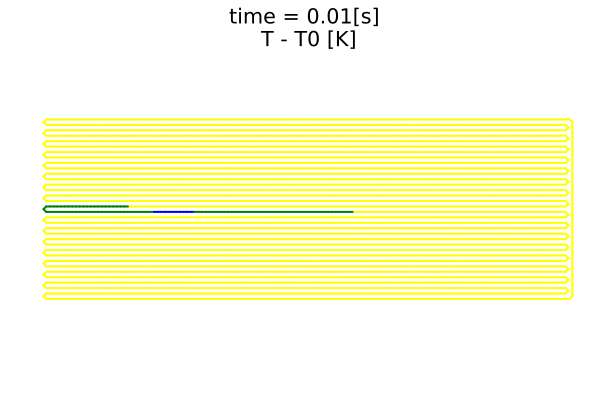

In [457]:
@gif for i=1:1:length(sysfinal)
    Htmp = sys_to_Harray(sysfinal[i])
    Htmp_marker = round.(div.(Htmp,Hₗ-1e-10))
    plot(ohp,clim=(0,2),fillalpha=0,linewidth=2.0,linecolor=palette([:yellow,  :blue, :green]),line_z=Htmp_marker,xlabel="x ",ylabel="y ",title=string("time = ", round(tube_hist_t[i], digits=2), "[s] \n",  "T - T0 [K]"),border=:none,axis=nothing)
end

In [458]:
? Xpto

search: XptoLvaporplug XptoLliquidslug Exception ErrorException RemoteException

Couldn't find Xpto
Perhaps you meant X0, XRGB, XYZ, XYZA, dXdt0, Out, p, prob, mp4, pie or plot


No documentation found.

Binding `Xpto` does not exist.


In [459]:
L_hist = []
δ_film=[]
for i=1:length(sysfinal)
    Lfilm_end = sysfinal[i].vapor.Lfilm_end[1]
    δ_film_end = sysfinal[i].vapor.δend[1]
    push!(L_hist,Lfilm_end)
    push!(δ_film,δ_film_end)
end

L_hist = Float64.(L_hist);
δ_film = Float64.(δ_film);

In [462]:
L_hist[end]

0.06709627363623323

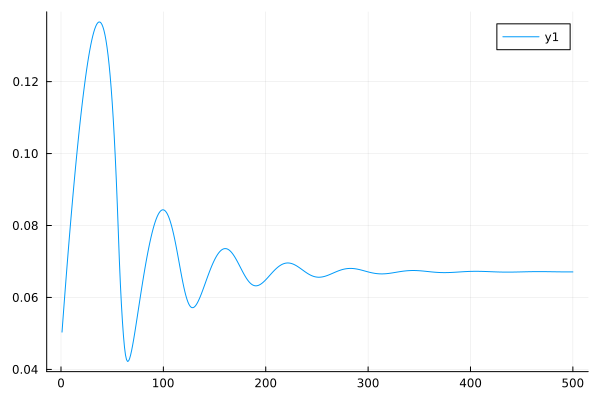

In [460]:
plot(L_hist)

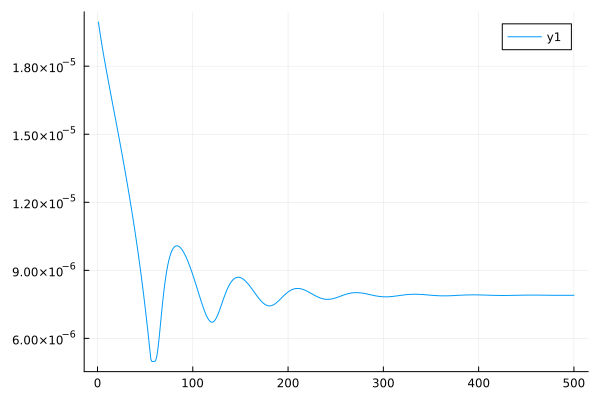

In [461]:
plot(δ_film)